<a href="https://colab.research.google.com/github/jihyuk1023/AI_physics/blob/main/04_Fully_Connected_Neural_Network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Learning Algorithm

딥러닝의 알고리즘은 크게 다음과 같이 구성되어 있습니다.



> feedforward

 feedforward는 주어진 input에 weight와 bias를 곱해서 출력을 얻어내는 것입니다.
즉, 뉴런 세포들이 있을 때 자극이 주어지면 특정 뉴런들이 활성화되는 것처럼 출력 뉴런까지 결과를 얻어내는 것입니다.

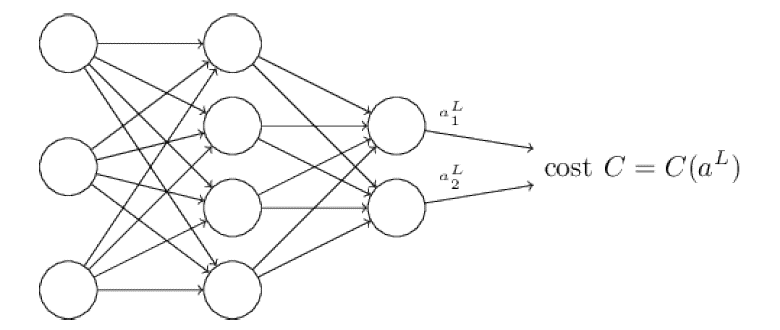

In [ ]:
path = '/content/neural network.png'
from IPython.display import Image
Image(filename=path, width=700)


>  Cost function의 계산


 Cost function은 우리가 원하는 답과 모델이 예측한 답이 얼마나 차이나는가를 의미합니다. 원하는 답에 따라 다른 Cost function을 사용할 수 있을 것입니다.
classification 문제에서는 Cross-Entropy가 주로 사용됩니다. 

    cross entropy는 주어진 답이 1 또는 0 뿐일 때 사용하는 cost function입니다. 정답을 y, 예측값을 y_hat 라고 하면 cross entropy는 아래와 같이 정의됩니다.

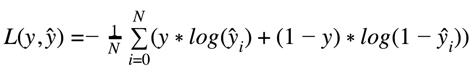

In [ ]:
path = '/content/binary_crossentropy.png'
Image(filename=path, width=500)

저번 시간에 주어진 데이터를 원-핫 인코딩 한 이유도 여기에 있습니다. label들을 원-핫 인코딩하게 되면 출력층의 뉴런들은 1, 0의 값만을 갖게 되므로
Cross entropy를 cost function으로 사용할 수 있습니다.

> back propagation (오차 역전파)


 back propagation은 weight와 bias가 cost function에 의해 얼마나 수정되어야 하는가를 의미합니다.
 선형 회귀 문제에서 우리가 weight를 수정할 때 w_rate라는 변수를 사용하여 weight가 변화할 때 cost가 어떻게 변화하는지를 관찰했습니다. 모든 뉴런의 weight가 변하면 cost의 변화는 어떻게 되는가? cost의 최솟값을 찾기 위해 neuron weight에 따른 cost의 gradient 방향을 찾는 것. 즉 다시 말해 각 뉴런의 (dC/dw) 값을 찾는 것이 back propagation의 목표라고 할 수 있습니다.




> weight , bias 수정



 back propagation을 통해 얻은 cost 함수의 gradient 방향으로 weight와 bias를 수정합니다.


이 과정을 주어진 데이터셋에 대해 반복합니다. 전체 데이터에 대해 1-4의 과정을 한 번 수행하는 것이 **epoch**입니다. 

epoch을 늘림에 따라서 데이터는 training dataset의 특성을 더 잘 반영하게 됩니다. 그러나 이것이 새로운 데이터에 대해서도 잘 맞는다는 뜻은 아닙니다. training dataset은 잘 반영하지만 실제 데이터는 잘 반영하지 못할 때, 이를 overfitting 상태라고 부릅니다.
epoch이 부족하여 training dataset도 잘 반영하지 못할 때, 이를 underfitting 상태라고 말합니다.
이를 확인하며 데이터를 학습시키는 것을 교차 검층 (cross validation)이라고 부릅니다.

# Stocastic Gradient Descent

Gradient descent에서 전체 데이터 셋의 Cost function은 보통 모든 데이터들의 loss function을 구한 뒤 에 그 평균값으로 구합니다. 그러나, 이 경우 모든 데이터(batch라고 부릅니다.)를 메모리에 저장한 뒤 loss function을 구해야 하기 때문에 매우 비효율적입니다. 이 문제를 해결하기 위해 Stocastic Gradient Descent를 이용합니다. 

Stocastic Gradient Descent를 직역하면 확률적 경사 하강법입니다. 확률적이라는 말에서 알 수 있 듯이, 이 방법은 전체 데이터에서 몇개의 표본을 추출합니다. (mini-bach라고 부릅니다.)무작위로 추출된 표본의 개수가 '큰 수의 법칙'(약 30개)를 만족하면 전체 데이터를 대표한다고 할 수 있습니다. 따라서, 이 표본들의 Cost function의 평균값을 **전체 데이터 셋의 cost function과 동일하다고 보고**
이 cost function에 back propagation을 수행하는 것입니다. 아래 코드의 batch_generator를 잘 살펴보면, batch를 어떻게 생성하는지 알 수 있을 것입니다.

# 딥러닝 모델 생성

In [ ]:
import os
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from abc import *
import sys
import tqdm
import joblib

모델 클래스를 생성합니다.

먼저 추상 클래스를 생성합니다. 모든 클래스가 주어진 메소드는 반드시 포함해야 한다는 의미의 추상 클래스를 정의했습니다. 일반적으로 모델이 가진 메소드들은 다음과 같이 쓸 수 있습니다.

- 모델은 layers 리스트를 갖습니다.
- append_layer는 모델에 레이어를 추가합니다.
- compile은 모델의 레이어를 확정합니다. 레이어가 확정되므로 weight와 bias 파라미터들을 생성해야합니다.
- forward는 모델을 통과한 input이 output을 예측하도록 합니다.
- backpropagation은 loss의 값을 역전파 하여 모델의 기울기를 계산합니다.
- loss는 Cost function의 값을 의미합니다.
- fit은 training set의 forward, backward 이후 기울기를 수정합니다.

layer class를 만들겠습니다. layer는 모델에 들어갈 각 층이며, 뉴런의 개수만을 그 성질로 가지는 오브젝트로 생성하였습니다. 

In [ ]:
import tensorflow as tf
from tensorflow.keras.utils import to_categorical

mnist = tf.keras.datasets.mnist
(x_train, y_train),(x_test, y_test) = mnist.load_data()
x_train = x_train / 255.0
x_test = x_test / 255.0

y_train_encoded = to_categorical(y_train, 10)
y_test_encoded = to_categorical(y_test, 10)

x_train = x_train.reshape(-1, 784)
x_test = x_test.reshape(-1,784)

x_val = x_train[54000:]
y_val_encoded = y_train_encoded[54000:]
x_train = x_train[:54000]
y_train_encoded = y_train_encoded[:54000]


11493376/11490434 [==============================] - 0s 0us/step


In [ ]:
def sigmoid(x):
  return 1 / (1+np.exp(-x))

def softmax(array):
  return np.exp(array) / np.sum(np.exp(array), axis = 1)



class layer():
  '''
  layer class. Dense층을 형성합니다.
  '''
  def __init__(self, n_neuron):
    self.n_neuron = n_neuron
    self.layers = []



class Model(ABC):
  def __init__(self):
    self.layers = []
    self.compiled = False
  
  @abstractmethod
  def append_layer(self, n_neuron):
    pass
  
  @abstractmethod
  def compile(self):
    self.compiled = True
    pass

  @abstractmethod
  def forward(self, x):
    pass

  @abstractmethod
  def backpropagation(self, x, output):
    pass

  @abstractmethod
  def loss(self, x, output):
    pass

  @abstractmethod
  def fit(self, x, output, epochs, batch_size):
    pass

In [ ]:
class FCNet(Model):
  '''
  Fully Connected net 을 생성합니다.
  '''
  def __init__(self):
    super().__init__()

  def append_layer(self, n_neuron):
    self.layers.append(layer(n_neuron)) #layer object들을 추가합니다. layer object는 n_neuron을 그 속성으로 가집니다. 따라서, model.append_layer(300)은 뉴런의 개수가 300개인 레이어가 모델에 추가됩니다.

  def compile(self):
    self.weight = [] # 각 층의 weight를 담을 리스트를 생성합니다.
    self.bias = [] # 각 층의 bias를 담을 리스트를 생성합니다.
    self.len_layers = len(self.layers) # layer의 개수를 의미합니다. 
    for i in range(self.len_layers - 1): # weight, bias는 각 층의 연결시에 필요하므로 그 개수는 레이어 개수보다 한 개 적습니다.
      W = np.random.normal(0, 1, (self.layers[i].n_neuron, self.layers[i+1].n_neuron)) # 각 층의 weight는 [입력층 뉴런 수, 출력층 뉴런 수]의 파라미터를 가집니다.
      b = np.random.normal(0, 1, (self.layers[i+1].n_neuron)) # 각 층의 bias는 [출력층 뉴런수]개의 파라미터를 가집니다.
      self.weight.append(W) # 리스트에 weight를 저장합니다.
      self.bias.append(b)
    self.compiled = True

  def forward(self, batch):
    self.layer_outputs = [batch] # layer_outputs를 생성합니다. 이는 각 출력층의 값들입니다. 첫 번째 원소는 input이여야 하므로, 입력받은 batch를 이미 리스트로 가지고 있습니다.
    for index, (weight, bias) in enumerate(zip(self.weight, self.bias)): # enumerate 함수는 index, object를, zip 함수는 두 object를 동시에 호출하는 함수입니다.
      new_batch = np.dot(batch, weight) + bias # 다음 층의 출력을 계산합니다. Wx + b
      new_batch = sigmoid(new_batch) # activation 함수를 통과시킵니다.
      if index == self.len_layers - 1: # 마지막 층에서는 
        new_batch = softmax(new_batch) # softmax함수에 통과시킵니다.(전체 확률은 1이 됩니다.)
      batch = new_batch # 다음 층에도 이를 통과시키기 위해 batch를 new_batch로 변경합니다.
      self.layer_outputs.append(batch) # layer_outputs에 출력층의 값을 추가해줍니다.

  def loss(self, prediction, output): # Cross entropy 값을 loss로 갖는 함수입니다.
    cross_entropy = - (np.sum(output * np.log(prediction) + (1-output) * np.log(1-prediction))) / len(output)
    return cross_entropy
  
  def accuracy(self, predict, output):
    return np.where(np.argmax(predict, axis = 1) == np.argmax(output, axis=1), 1,0).sum() / len(output)


In [ ]:
model = FCNet()
model.append_layer(784)
model.append_layer(128)
model.append_layer(10)
model.compile()
model.fit(x_train, y_train_encoded, 10, 32, x_test, y_test_encoded)

  0%|          | 0/1688 [00:00<?, ?it/s]

one epoch ends.... loss = 0.481511909357461
                   acc  = 0.9375

val_accuracy = 0.9336
val_loss = 0.47591671396874036


  0%|          | 0/1688 [00:00<?, ?it/s]

one epoch ends.... loss = 0.300002556605595
                   acc  = 1.0

val_accuracy = 0.9452
val_loss = 0.37976871042028004


  0%|          | 0/1688 [00:00<?, ?it/s]

one epoch ends.... loss = 0.24029356236191202
                   acc  = 0.96875

val_accuracy = 0.9489
val_loss = 0.3601954153721509


  0%|          | 0/1688 [00:00<?, ?it/s]

one epoch ends.... loss = 0.22266583927704986
                   acc  = 0.96875

val_accuracy = 0.9539
val_loss = 0.3497872434729226


  0%|          | 0/1688 [00:00<?, ?it/s]

one epoch ends.... loss = 0.16062501631661635
                   acc  = 1.0

val_accuracy = 0.9539
val_loss = 0.33916347228769583


  0%|          | 0/1688 [00:00<?, ?it/s]

one epoch ends.... loss = 0.12573791580899774
                   acc  = 1.0

val_accuracy = 0.9564
val_loss = 0.33175535073046813


  0%|          | 0/1688 [00:00<?, ?it/s]

one epoch ends.... loss = 0.09120726164390995
                   acc  = 1.0

val_accuracy = 0.959
val_loss = 0.3231791069385466


  0%|          | 0/1688 [00:00<?, ?it/s]

one epoch ends.... loss = 0.06312334982755112
                   acc  = 1.0

val_accuracy = 0.9604
val_loss = 0.31585098965068104


  0%|          | 0/1688 [00:00<?, ?it/s]

one epoch ends.... loss = 0.047960065757460466
                   acc  = 1.0

val_accuracy = 0.9612
val_loss = 0.31013163050963244


100%|██████████| 1688/1688 [00:36<00:00, 46.00it/s]


one epoch ends.... loss = 0.03876794408794912
                   acc  = 1.0

val_accuracy = 0.9625
val_loss = 0.30696689285495665


제어 가능한 변수 
1. weight inistallization
2. loss 종류 - Cross Entropy, Mean Sqaured Error
3. L1 규제, L2 규제
4. learning rate
5. batch size
6. epochs -> early stopping

In [ ]:
def savemodel(filename, model):        
  joblib.dump(model,filename) 

In [ ]:
model